In [101]:
import sys
import os
import importlib
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Use the absolute path to the src directory
sys.path.append('../src')

import process.process as pr 
import evaluation.eval  as ev
import models.fit as f
# Test import first
file_path = '../CC_GENERAL.csv'

importlib.reload(pr)
importlib.reload(ev)
importlib.reload(f)

df = pr.read_data(file_path)
df.head()
print(f"we have {df.shape[0]} rows and {df.shape[1]} columns")
df.info()


we have 8950 rows and 17 columns
<class 'pandas.core.frame.DataFrame'>
Index: 8950 entries, C10001 to C19190
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   balance                           8950 non-null   float64
 1   balance_frequency                 8950 non-null   float64
 2   purchases                         8950 non-null   float64
 3   oneoff_purchases                  8950 non-null   float64
 4   installments_purchases            8950 non-null   float64
 5   cash_advance                      8950 non-null   float64
 6   purchases_frequency               8950 non-null   float64
 7   oneoff_purchases_frequency        8950 non-null   float64
 8   purchases_installments_frequency  8950 non-null   float64
 9   cash_advance_frequency            8950 non-null   float64
 10  cash_advance_trx                  8950 non-null   int64  
 11  purchases_trx                     

## what is this dataset?

source: kaggle

describes the behavior of about 9000 credit holders over a period of 6 months.

it includes 18 features.

NULL values in:
credit_limit          1
minimum_payments    313
dtype: int64


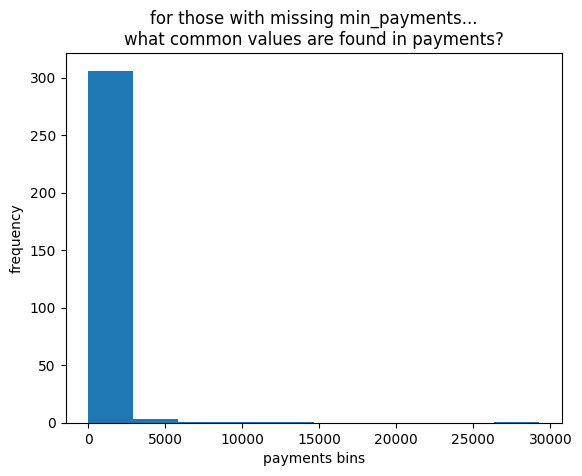

0.767


In [75]:
print(f'NULL values in:\n{df.isna().sum()[df.isna().sum() > 0]}')

plt.plot()
plt.hist(df.loc[df['minimum_payments'].isna(), 'payments'])
plt.xlabel("payments bins")
plt.ylabel("frequency")
plt.title(
    "for those with missing min_payments...\nwhat common values are found in payments?")
plt.show()

# we think there's a connection between having a missing min payment and a payments of 0
mask = (df['minimum_payments'].isna()) & (df['payments'] == 0)
print(round(df.loc[mask, :].shape[0]/313, 3))



we're going to impute min payments...and we can take a number of different approaches

just take the average or median of min payment data that we do have, and impute using that
throw away the rows with missing data
we'd probably be justified in doing that here because the proportion of missing data is relat, but that's no fun

model based imputation (from very simple to very complex)
example of a simple approach: constant of proportionality

find another one of the features that is highly correlated with min payments (e.g. payments)
take the ratio avg(min payments)/avg(payments) = C
and let missing min payments be defined as payments*C
a little bit of algebra:

payments*C = min payments

C = min payments / payments

think of this as "baby" linear regression

you can of course actually do a regression and impute using that

In [76]:
df.corr()['minimum_payments'].abs().sort_values(ascending=False)[:5]


minimum_payments     1.000000
balance              0.398684
prc_full_payment     0.140379
cash_advance         0.140107
balance_frequency    0.132569
Name: minimum_payments, dtype: float64

In [77]:
# Model Evaluation
print("Evaluating imputation methods...")
r2_constant, r2_linear = ev.evaluate_imputation(df)
print(f"R-squared for Constant Proportionality: {r2_constant}")
print(f"R-squared for Linear Regression: {r2_linear}")


Evaluating imputation methods...
R-squared for Constant Proportionality: 0.1509017635738128
R-squared for Linear Regression: 0.19672360257016308


In [78]:
#Imputation 
print("Imputation missing values using linear regretion...")
pr.impute_missing_values(df)

# that pesky credit limit missing value - drop it like its hot
df.dropna(inplace=True)

print(f"total null values in data frame {df.isna().sum().sum()}")


Imputation missing values using linear regretion...
total null values in data frame 0


## inspect distributions, scale the data, check for the presence of extreme values
one important intuition about clustering is the following:

we will often transform our data to make it more amenable to clustering, make it less interpretable (scaling, log transforms etc.) but this is totally fine

once we have cluster labels, we can map them back to the original data that we know how to interpret.

to-do

visual inspection (make a bunch of histograms)
note the presence of outliers
we need to ensure the data is on the same scale.
decide how to scale the data (normalize (0-1), standardize (map to normal distribution), ....)

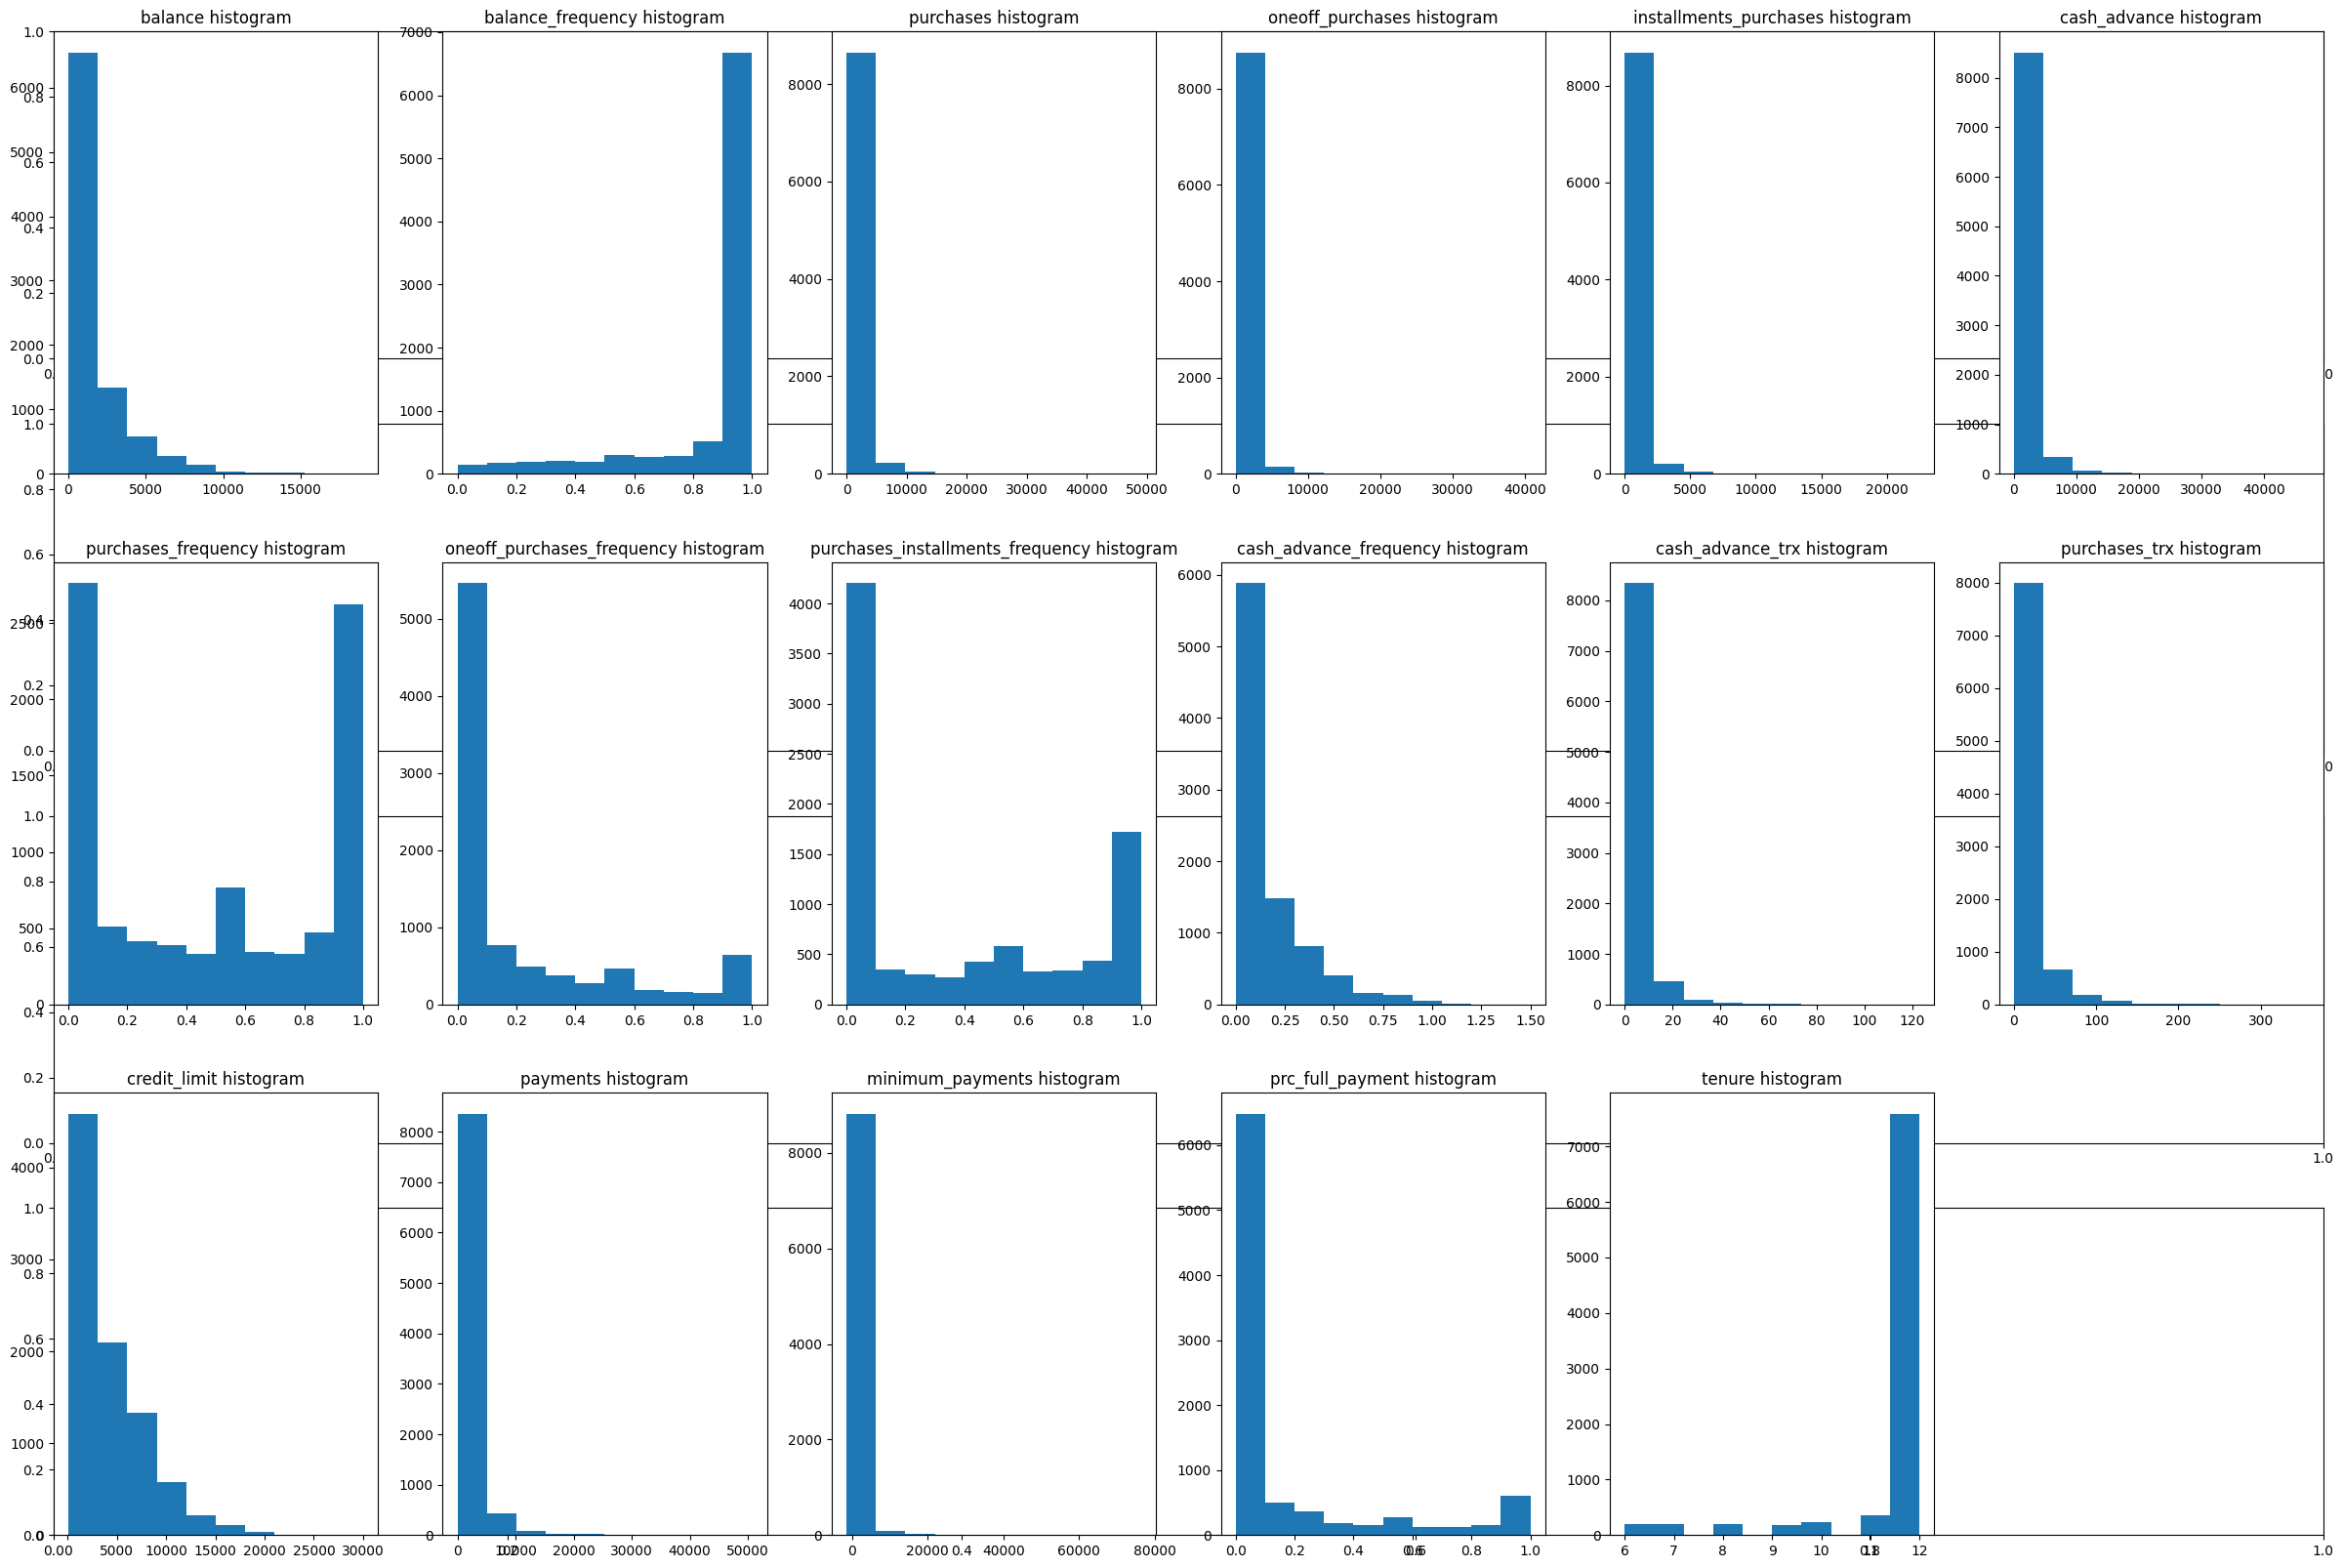

In [79]:
#visual inspection
plt.subplots(4, figsize=(30, 20))

for i, col in enumerate(df.columns):
    plt.subplot(3, 6, i+1)
    plt.hist(df[col])
    plt.title(f"{col} histogram")

plt.show()

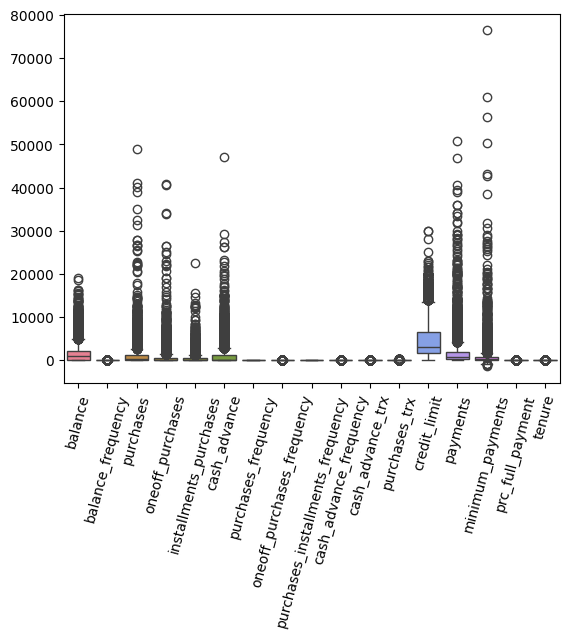

In [80]:
# distributions
fig, axis = plt.subplots(1,1)
sns.boxplot(df,ax = axis)
axis.tick_params(axis = 'x',rotation = 75)

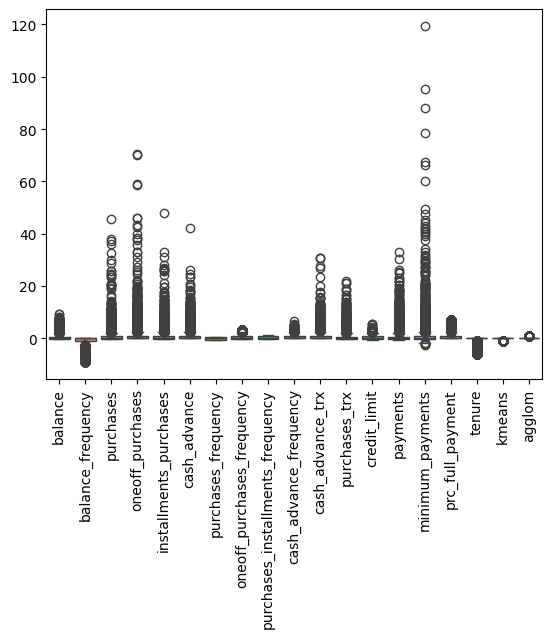

In [89]:
# minmax scaling
scaled = pr.scale_data(df)

# hows our distribution looking?
fig, axis = plt.subplots(1,1)
sns.boxplot(scaled,ax = axis)
axis.tick_params(axis = 'x',rotation = 90)


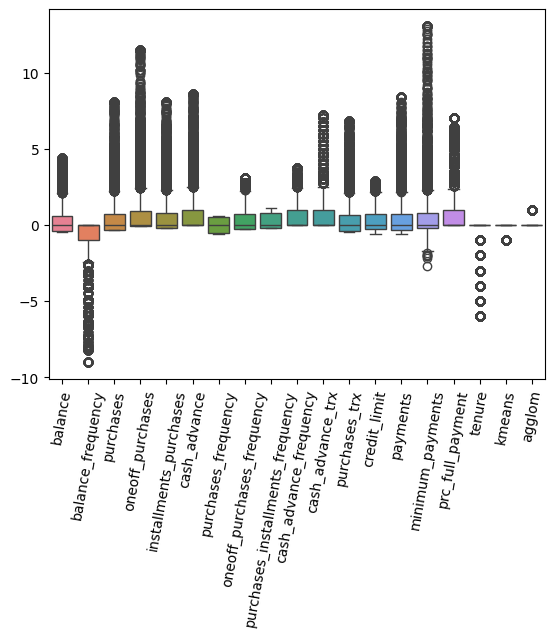

In [91]:
# ready to force extreme values into a reasonable range
# winsorize to the 99th percentile
windsor = pr.windsor_data(scaled.copy())

fig, axis = plt.subplots(1,1)
sns.boxplot(windsor,ax = axis)
axis.tick_params(axis = 'x',rotation = 80)

## Clustering
first algo: K means

objective: find clusters (find groups of data points that are more similar to each other than they are to points in other groups)

how does K means work

you tell K means how many clusters we want it to find (that's the K parameter)
it will randomly generate K points in the feature space - these are the initial "cluster centers"
for every data point (every customer) we calculate the distance between them and each of the cluster centers
the data point is then assigned to the closest cluster center
for each cluster center, we reposition it by calculating the average of all the points that now belong to it
we repeat steps 3, 4 and 5, until the cluster centers no longer move.
at the end of this we have our clustering.

before we fit the model we need to talk about model evaluation.

inertia lets us quantify how good our clusters are

definition:

recall that every cluster has a cluster center -- so -- for every data point assigned to a cluster take the squared distance between it and the cluster center then add up these numbers.

simple example: (5,18) = cluster center (c) (4,17) and (3,16) are the two points in the cluster (p1,p2) d(c,p1)^2 + d(c,p2)^2 = sum of squared distances

then... do this for all the other clusters

then... add up all of these numbers

that's inertia.

what's the intuition?

do we want inertia to be small or large in order to believe that we have good clusters?

we want inertia to be small

our procedure: experiment with the k parameter -- fit a kmeans for each value of k in a range of k that you want to experiment with, then graph k vs inertia. this is an example of a more general pattern in machine learning called hyperparameter optimization.

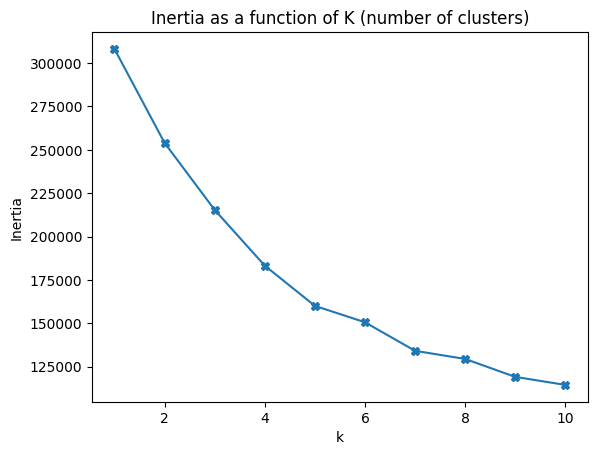

Best K based on Inertia: 1


In [100]:
# experiment with the k parameter -- fit a kmeans for each value of k in a range of k
ks, inertias = f.perform_kmeans(windsor)
ev.plot_scores(ks, inertias, "Inertia")
ev.evaluate_clusters(ks, inertias, "Inertia")


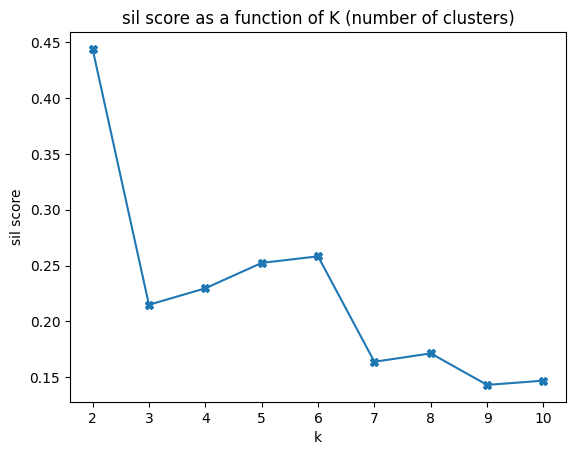

Best K based on Silhouette Score: 2


In [83]:
# Perform Agglomerative Clustering
ks, sil_scores = f.fit_agglomerative_clustering(windsor)
ev.plot_scores(ks, sil_scores, 'sil score')
ev.evaluate_clusters(ks, sil_scores, "Silhouette Score")


In [84]:
# Final clustering with chosen k
final_kmeans = KMeans(n_clusters=2, n_init='auto')
final_kmeans.fit(windsor)

final_agglom = AgglomerativeClustering(n_clusters=2)
final_agglom.fit(windsor)

# Compare models
ev.compare_models(final_kmeans.labels_, final_agglom.labels_)


original labels
kmeans     0     1
agglom            
0       6741  1682
1        522     4
table with the kmeans labels flipped (0 -> 1 and vice versa)
kmeans     0     1
agglom            
0       1682  6741
1          4   522


In [85]:
import numpy as np 
print(f"percentage agreement between models: {np.round(100*(5895 + 509)/windsor.shape[0],1)}%")

percentage agreement between models: 71.6%


In [86]:
tsne_data = f.perform_tsne(windsor)

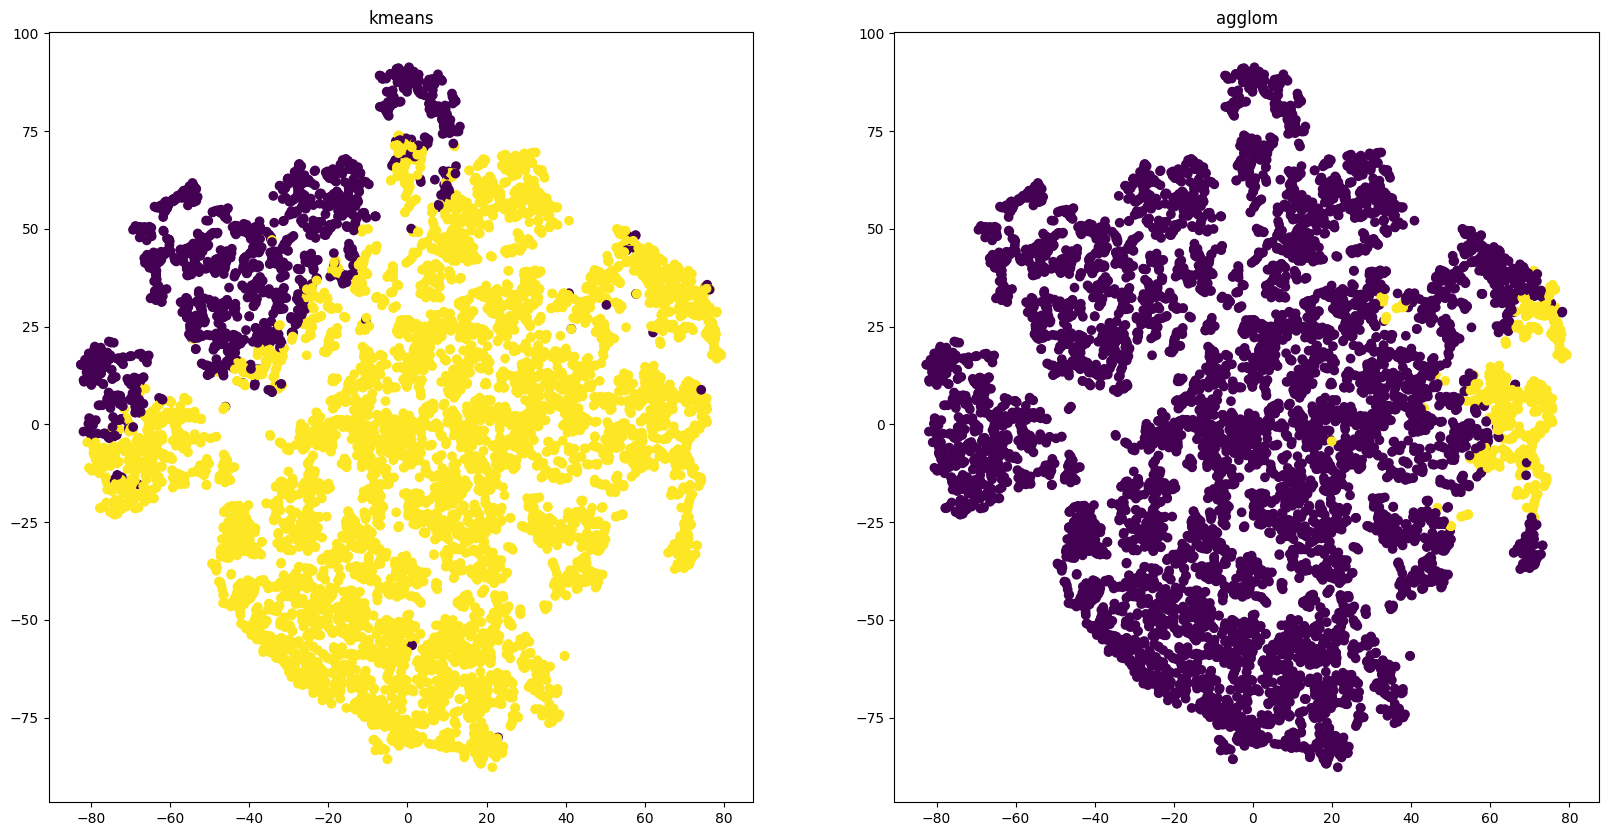

In [87]:
# Visualize clusters using TSNE
f.visualize_clusters(tsne_data, final_kmeans, final_agglom)


For balance, the ratio of medians between group 1 and group 0 is: 37.0
For balance_frequency, the ratio of medians between group 1 and group 0 is: 2.0
For purchases, the ratio of medians between group 1 and group 0 is: 2.0
For oneoff_purchases, the ratio of medians between group 1 and group 0 is: inf
For installments_purchases, the ratio of medians between group 1 and group 0 is: 3.0
For cash_advance, the ratio of medians between group 1 and group 0 is: inf
For purchases_frequency, the ratio of medians between group 1 and group 0 is: 2.0
For oneoff_purchases_frequency, the ratio of medians between group 1 and group 0 is: inf
For purchases_installments_frequency, the ratio of medians between group 1 and group 0 is: 3.0
For cash_advance_frequency, the ratio of medians between group 1 and group 0 is: inf
For cash_advance_trx, the ratio of medians between group 1 and group 0 is: inf
For purchases_trx, the ratio of medians between group 1 and group 0 is: 3.0
For credit_limit, the ratio of m

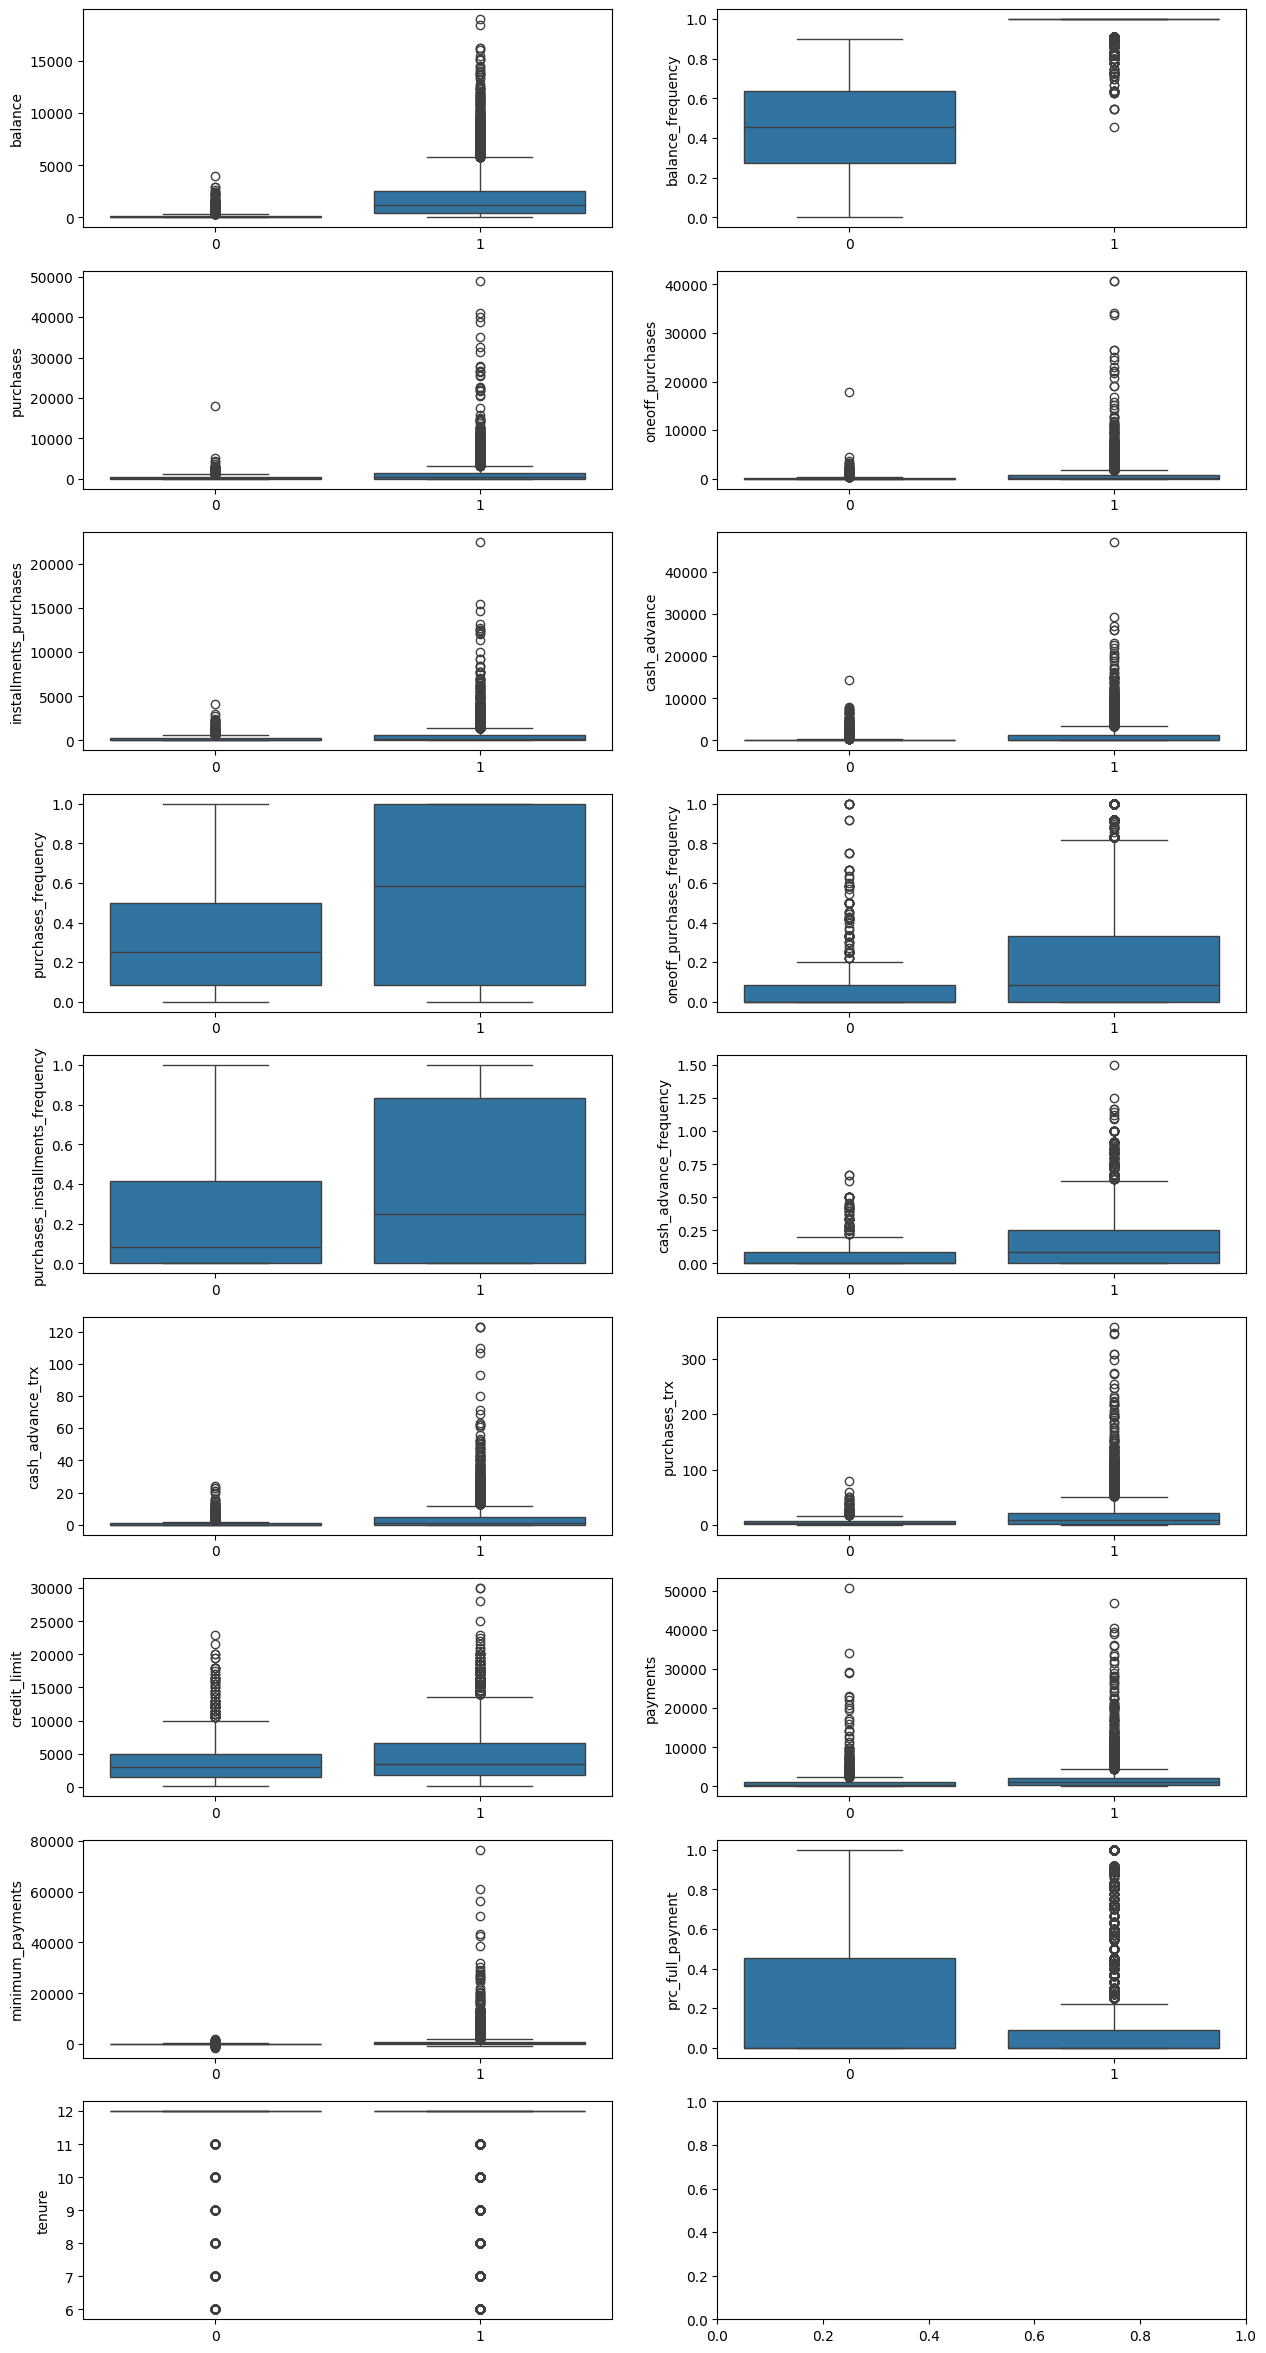

In [88]:
# Attach cluster labels back to original data
df['kmeans'] = (~final_kmeans.labels_.astype(bool)).astype(int)
df['agglom'] = final_agglom.labels_

ev.column_compare(df)
